# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


### The aim here is an investigation of the source of the cold/fresh blob which appeared in the near-surface Iceland Basin from about 2014. There are a couple of published explanations for the feature: 

- reduced heat/salt transport across RAPID array and northwards to subpolar N Atlantic over several years (Bryden et al. 2020?) or 
- increased contribution from Labrador Sea water flowing into subpolar North Atlantic rather than southwards (Holliday et al. 2020?). Driven I think by specific,  more intermittent, weather near Flemish Cap (though I need to read this again...)

The technique is to track particles back from the OSNAP line for 4 years and identify those which came from the Gulf Stream and those which came through the Labrador Sea. And see how that changes between from 2006 to 2017. (Elsewhere I have done backwards particle tracking for all years between 2006 and 2017. This supports the results shown here and adds some detail, but 2 years tracking isn't really long enough to identify pathways). I am also trying to quantify the volume/heat/salt transports along each route (not here yet though).

## This notebook plots out the tracks and implements some source tests

## Technical preamble

In [1]:
%matplotlib inline

In [2]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy
import seawater as sw

from matplotlib import colors as c
from matplotlib import ticker
from xhistogram.xarray import histogram

In [3]:
sns.set(style="darkgrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=20) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Set up paths and read in trajectory data

In [4]:
## Parameters
# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# output figures path
figures_path = Path("reports/figures/ColdBlob/")

# Parcels track data file
path_data_tracks = Path('data/processed/tracks/gulfstream/') 
filename_tracks = [
                   'tracks_randomvel_gs_forwards_201201_N29412_D365_Rnd123.nc'
                   
]

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/sections/')
sectionFilename = 'gs_pos_wp.txt'
sectionname = 'gulfstream'

degree2km = 1.852*60.0


## Load data

### mesh and masks

In [5]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

In [6]:
mesh_mask.gdepw_0[:,0,0]


<xarray.DataArray 'gdepw_0' (z: 46)>
array([   0.      ,    6.194242,   12.839149,   20.04454 ,   27.946293,
         36.712124,   46.548466,   57.708504,   70.50136 ,   85.30241 ,
        102.56431 ,  122.82839 ,  146.73515 ,  175.03276 ,  208.58119 ,
        248.3496  ,  295.4039  ,  350.88147 ,  415.9509  ,  491.7565  ,
        579.3501  ,  679.6166  ,  793.2019  ,  920.4562  , 1061.4005  ,
       1215.7251  , 1382.8185  , 1561.822   , 1751.701   , 1951.3186  ,
       2159.5059  , 2375.1194  , 2597.082   , 2824.4119  , 3056.2346  ,
       3291.788   , 3530.419   , 3771.574   , 4014.7896  , 4259.681   ,
       4505.9326  , 4753.283   , 5001.522   , 5250.476   , 5500.0063  ,
       5750.      ], dtype=float32)
Coordinates:
    nav_lon  float32 ...
    nav_lat  float32 ...
    nav_lev  (z) float32 ...
Dimensions without coordinates: z
Attributes:
    cell_methods:  t: mean

### tracks

In [7]:
for i,filename in enumerate(filename_tracks):
    dst=xr.open_dataset(project_path / path_data_tracks / filename)
    if i == 0:
        ds=dst
    else:
        ds=xr.concat([ds,dst],dim='traj')


In [8]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

#### Extract fields on osnap line (obs=0). Find 'initial' velocities normal to the section.

These are the positions we 'initialised' the particles with, but we ran particles backwards in time so these  represent the final positions, on the osnap line.

In [9]:
ds_init = ds.isel(obs=0)

## plot tracks by source region

In [10]:
# range of stations from west to east, stations 0-12. Python indexing.

def plotTracksCartopy(ds1,cmap=co.cm.tempo_r,title='',fig_path = Path.cwd(),fileroot='',date = ''):
    
    central_lon, central_lat = -45, 29
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize = (12,8),subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
    extent = [-80, -10, 5, 50]
    ax.set_extent(extent)
    ax.gridlines()
    ax.coastlines(resolution='50m')
    
    dsmask = ds1

    pcm = ax.scatter(
        dsmask.lon.data.flatten(),
        dsmask.lat.data.flatten(),
        3,
#         mdates.date2num(dsmask.time.data.flatten())
        dsmask.z.data.flatten()
        ,cmap= cmap
        ,zorder=2
        ,transform=ccrs.PlateCarree()
    #   ,alpha=0.3
    )
    cb = fig.colorbar(pcm,ax=ax,shrink=0.8,label = "date")
#     loc = mdates.MonthLocator(bymonth=range(1,13,3))
#     cb.ax.yaxis.set_major_locator(loc)
#     cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
#     cb.ax.tick_params(labelsize=20)


    depth.isel(y=slice(1000, 2499), x=slice(0, 2404)).plot.contour(ax=ax,transform=ccrs.PlateCarree(),
        x="nav_lon", y="nav_lat", colors = 'grey', levels = [200,800,1500,2000,2500,3500],zorder=1
    );
    ax.scatter(
        dsmask.lon.isel(obs=0).data.flatten(),
        dsmask.lat.isel(obs=0).data.flatten(),2,zorder=5,
        transform=ccrs.PlateCarree()
    )
    
    title=ax.set_title(title)
    
    filenameroot = fig_path / str('plotTracks' + fileroot + date)

#     plt.savefig(filenameroot.with_suffix('.eps'), bbox_extra_artists=(title,), bbox_inches='tight')
#     plt.savefig(filenameroot.with_suffix('.png'), bbox_extra_artists=(title,), bbox_inches='tight')
#     plt.savefig(filenameroot.with_suffix('.pdf'), bbox_extra_artists=(title,), bbox_inches='tight')


    return


In [11]:
t=[]

for name,group in ds_init.groupby("time"):
    t.append(name)  
    
display(t)


[numpy.datetime64('2012-01-16T12:00:00.000000000')]

### Particles reaching OSNAP section, 20-30W 0-500 m depth, from Labrador Sea.

It is difficult to see any change in the volume transort of water on this route from these plots, but there is a change in the pattern, with many fewer of the 2017 particles taking the southern loop down the east coast of Canada/USA than the 2006 particles.

This supports the Holliday et al idea of different routes out of the Labrador Sea influencing temperature/salinity in near-surface Iceland Basin. It also suggests a possible negative link between near-surface temperature in Iceland Basin and Atlantic coast of NE USA/Canada.

#### select by release date

In [12]:
date = str(t[0].astype('datetime64[D]'))
display(date)

'2012-01-16'

In [13]:
test = ds.isel(traj=slice(0,None,10))
ds_select = test.where(test.isel(obs=0).time == t[0]).dropna('traj', how='all')

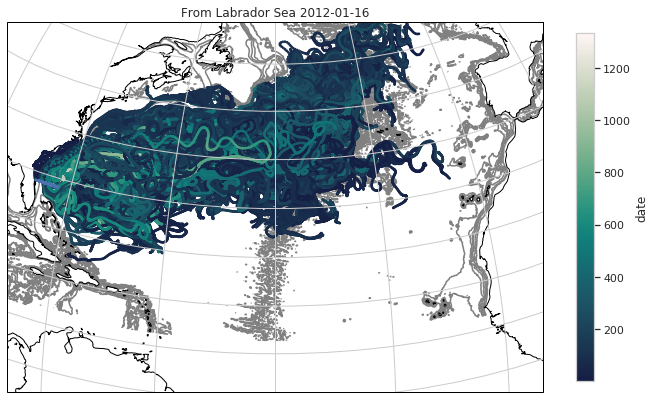

In [14]:
plotTracksCartopy(ds_select,cmap=co.cm.tempo_r,title='From Labrador Sea '+date,fig_path = project_path / figures_path, fileroot='Lab',date=date)

In [66]:
# conda list